In [1]:
# Protein Fitness Predictors: EV, One-Hot, and Joint Models
# This notebook demonstrates predictor classes for protein fitness prediction

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

import os
import joblib
import numpy as np
from loguru import logger
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge

# Note: These imports would normally work if util and couplings_model were installed
# For demonstration, we'll define minimal versions inline
import sys
sys.path.insert(0, '/home/xux/Desktop/ProteinMCP/ProteinMCP/mcp-servers/ev_onehot_mcp/repo/ev_onehot')
from util import spearman, seqs_to_onehot, seq2effect
from couplings_model import CouplingsModel
from Bio import SeqIO

In [2]:
REG_COEF_LIST = [1e-1, 1e0, 1e1, 1e2, 1e3]

In [3]:
def read_fasta(filename, return_ids=False):
    records = SeqIO.parse(filename, 'fasta')
    seqs = list()
    ids = list()
    for record in records:
        seqs.append(str(record.seq))
        ids.append(str(record.id))
    if return_ids:
        return seqs, ids
    else:
        return seqs

In [4]:
class BaseRegressionPredictor:
    def __init__(self, data_path, reg_coef=None, linear_model_cls=Ridge):
        self.data_path = data_path
        self.reg_coef = reg_coef
        self.linear_model_cls = linear_model_cls
        self.model = None

    def seq2feat(self, seqs):
        raise NotImplementedError

    def train(self, train_seqs, train_labels):
        X = self.seq2feat(train_seqs)
        if self.reg_coef is None or self.reg_coef == 'CV':
            best_rc, best_score = None, -np.inf
            for rc in REG_COEF_LIST:
                model = self.linear_model_cls(alpha=rc)
                score = cross_val_score(model, X, train_labels, cv=5,
                                        scoring=make_scorer(spearman)).mean()
                if score > best_score:
                    best_rc = rc
                    best_score = score
            self.reg_coef = best_rc
            # print(f'Cross validated reg coef {best_rc}')
        self.model = self.linear_model_cls(alpha=self.reg_coef)
        self.model.fit(X, train_labels)

    def predict(self, predict_seqs):
        if self.model is None:
            return np.random.randn(len(predict_seqs))
        X = self.seq2feat(predict_seqs)
        return self.model.predict(X)

    def save_model(self):
        save_path = os.path.join(self.data_path, 'ridge_model.joblib')
        joblib.dump(self.model, save_path)
        logger.info(f"Ridge regression model saved to path {save_path}")

    def load_model(self):
        model_path = os.path.join(self.data_path, 'ridge_model.joblib')
        self.model = joblib.load(model_path)
        # logger.info(f"Ridge regression model loaded from path {model_path}")

In [5]:
class JointPredictor(BaseRegressionPredictor):
    """Combining regression predictors by training jointly."""

    def __init__(self, data_path, predictor_classes, predictor_name, reg_coef='CV'):
        super(JointPredictor, self).__init__(data_path, reg_coef)
        self.predictors = []
        for c, name in zip(predictor_classes, predictor_name):
            self.predictors.append(c(data_path, ))

    def seq2feat(self, seqs):
        # To apply different regularziation coefficients we scale the features by a multiplier in Ridge regression
        features = [p.seq2feat(seqs) * np.sqrt(1.0 / p.reg_coef) for p in self.predictors]
        return np.concatenate(features, axis=1)

In [6]:
class OnehotRidgePredictor(BaseRegressionPredictor):
    """Simple one hot encoding + ridge regression."""

    def __init__(self, data_path, reg_coef=1.0):
        super(OnehotRidgePredictor, self).__init__(data_path, reg_coef, Ridge)

    def seq2feat(self, seqs):
        return seqs_to_onehot(seqs)

In [7]:
class EVPredictor(BaseRegressionPredictor):
    """plmc mutation effect prediction."""

    def __init__(self, data_path, reg_coef=1e-8, ignore_gaps=False):
        super(EVPredictor, self).__init__(data_path, reg_coef=reg_coef)
        self.ignore_gaps = ignore_gaps
        self.couplings_model_path = os.path.join(data_path, 'plmc/uniref100.model_params')
        # logger.info(f"EVmutation model loaded from path: {self.couplings_model_path}")
        self.couplings_model = CouplingsModel(self.couplings_model_path)
        wtseqs, wtids = read_fasta(os.path.join(data_path, 'wt.fasta'), return_ids=True)
        if '/' in wtids[0]:
            self.offset = int(wtids[0].split('/')[-1].split('-')[0])
        else:
            self.offset = 1
        expected_wt = wtseqs[0]

        for pf, pm in self.couplings_model.index_map.items():
            if expected_wt[pf-self.offset] != self.couplings_model.target_seq[pm]:
                logger.debug(f'WT and model target seq mismatch at {pf}')

    def seq2score(self, seqs):
        return seq2effect(seqs, self.couplings_model, self.offset, ignore_gaps=self.ignore_gaps)

    def seq2feat(self, seqs):
        return self.seq2score(seqs)[:, None]

    def predict_unsupervised(self, seqs):
        return self.seq2score(seqs)

## Demonstration: OnehotRidgePredictor

Below we demonstrate the OnehotRidgePredictor class with synthetic data.

In [8]:
# Create synthetic training data
np.random.seed(42)
train_seqs = ["MRHKD", "DESTN", "QCUGP", "AVIFY", "WLOMR"]
train_fitness = np.array([0.5, 0.8, -0.2, 0.3, 0.6])

# Create a OnehotRidgePredictor (no data_path needed for demo)
predictor = OnehotRidgePredictor(data_path=".", reg_coef=1.0)

# Train the model
predictor.train(train_seqs, train_fitness)

# Make predictions on test sequences
test_seqs = ["MRHKE", "DESTP"]
predictions = predictor.predict(test_seqs)

print("OnehotRidgePredictor Demonstration")
print("=" * 50)
print(f"Training sequences: {len(train_seqs)}")
print(f"Feature matrix shape: {predictor.seq2feat(train_seqs).shape}")
print(f"\nTest predictions:")
for seq, pred in zip(test_seqs, predictions):
    print(f"  {seq}: {pred:.4f}")

OnehotRidgePredictor Demonstration
Training sequences: 5
Feature matrix shape: (5, 144)

Test predictions:
  MRHKE: 0.4667
  DESTP: 0.5667



One-hot encoding shape for 'MRHKD': (1, 144)


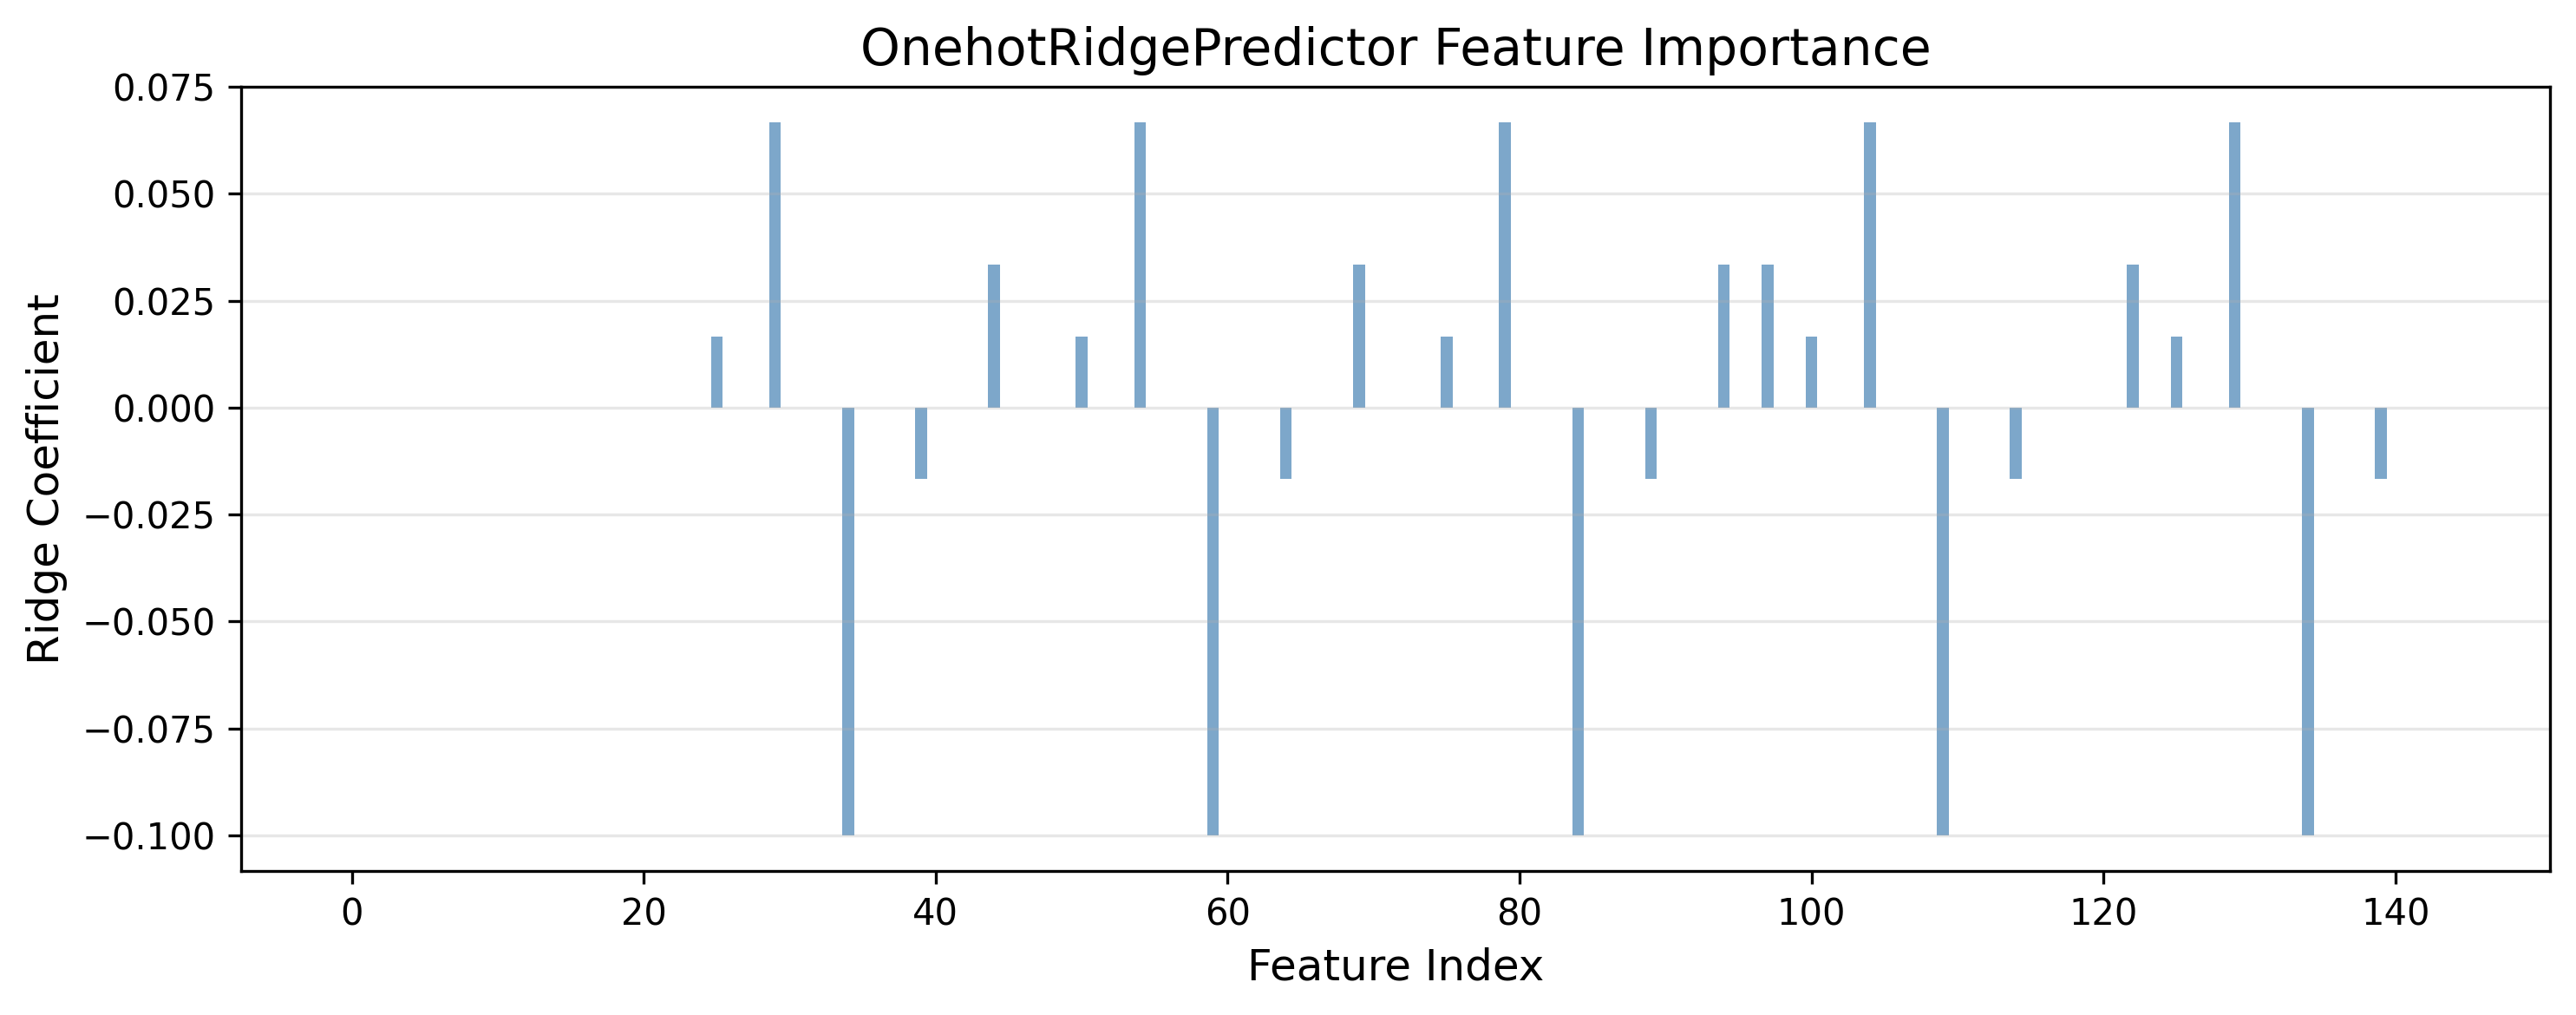


Feature importance visualization saved


In [9]:
# Visualize feature encoding
test_onehot = predictor.seq2feat(["MRHKD"])
print(f"\nOne-hot encoding shape for 'MRHKD': {test_onehot.shape}")

# Plot feature importance (ridge coefficients)
if predictor.model is not None:
    fig, ax = plt.subplots(figsize=(10, 4))
    coeffs = predictor.model.coef_
    ax.bar(range(len(coeffs)), coeffs, alpha=0.7, color='steelblue')
    ax.set_xlabel('Feature Index', fontsize=12)
    ax.set_ylabel('Ridge Coefficient', fontsize=12)
    ax.set_title('OnehotRidgePredictor Feature Importance', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('notebooks/predictor/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\nFeature importance visualization saved")